## 

In [1]:
import numpy as np
import pandas as pd
import sklearn
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vgg19
vgg_net = vgg19(weights =True)
import tqdm
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 63.6MB/s] 


## VGG19

In [2]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
data_dir = '/kaggle/input/face-recognition-dataset/Dataset/Faces'
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

dataset = ImageFolder(root=data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)


In [3]:
vgg_net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### TRAINING VGG19

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

vgg_net = models.vgg19(pretrained=True)
for param in vgg_net.features.parameters():
    param.requires_grad = False
num_classes = len(dataset.classes)
vgg_net.classifier.append( nn.Sequential(
    nn.Linear(1000, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, num_classes)
))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_net.parameters(), lr=1e-4)

num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_net.to(device)
print(device)

vgg_training_logs =[]
for epoch in tqdm(range(num_epochs)):
    epoch_log={}
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        vgg_net.eval()
        total_correct = 0
        total_samples = 0

        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = vgg_net(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            # accuracy
            _, predicted = torch.max(val_outputs, 1)
            total_correct += (predicted == val_labels).sum().item()
            total_samples += val_labels.size(0)

        accuracy = total_correct / total_samples

    vgg_net.train() 

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Accuracy: {accuracy * 100:.2f}%')
    epoch_log['Loss'] =loss.item()
    epoch_log['Validation Loss'] = val_loss.item()
    epoch_log['accuracy'] = accuracy
    
    vgg_training_logs.append(epoch_log)

torch.save(vgg_net.state_dict(), 'vgg_net_model.pth')


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


cuda


  1%|          | 1/100 [00:09<15:18,  9.28s/it]

Epoch 1/100, Loss: 2.8962886333465576, Validation Loss: 2.8864681720733643, Accuracy: 19.87%


  2%|▏         | 2/100 [00:14<11:26,  7.00s/it]

Epoch 2/100, Loss: 2.042607069015503, Validation Loss: 2.2988953590393066, Accuracy: 37.37%


  3%|▎         | 3/100 [00:19<10:00,  6.19s/it]

Epoch 3/100, Loss: 1.5400127172470093, Validation Loss: 1.915157437324524, Accuracy: 48.48%


  4%|▍         | 4/100 [00:25<09:16,  5.80s/it]

Epoch 4/100, Loss: 0.9119344353675842, Validation Loss: 1.7041436433792114, Accuracy: 54.21%


  5%|▌         | 5/100 [00:30<08:57,  5.66s/it]

Epoch 5/100, Loss: 0.49326369166374207, Validation Loss: 1.6772165298461914, Accuracy: 53.54%


  6%|▌         | 6/100 [00:35<08:37,  5.50s/it]

Epoch 6/100, Loss: 0.5201424360275269, Validation Loss: 1.6379563808441162, Accuracy: 59.60%


  7%|▋         | 7/100 [00:40<08:22,  5.40s/it]

Epoch 7/100, Loss: 0.23218505084514618, Validation Loss: 1.6197459697723389, Accuracy: 63.64%


  8%|▊         | 8/100 [00:46<08:15,  5.38s/it]

Epoch 8/100, Loss: 0.20157183706760406, Validation Loss: 1.6791774034500122, Accuracy: 64.98%


  9%|▉         | 9/100 [00:51<08:07,  5.36s/it]

Epoch 9/100, Loss: 0.15955974161624908, Validation Loss: 1.5518335103988647, Accuracy: 64.65%


 10%|█         | 10/100 [00:56<07:59,  5.32s/it]

Epoch 10/100, Loss: 0.05181260406970978, Validation Loss: 1.5643064975738525, Accuracy: 67.00%


 11%|█         | 11/100 [01:02<07:51,  5.30s/it]

Epoch 11/100, Loss: 0.05574750155210495, Validation Loss: 1.49177086353302, Accuracy: 69.02%


 12%|█▏        | 12/100 [01:07<07:44,  5.27s/it]

Epoch 12/100, Loss: 0.10297507047653198, Validation Loss: 1.433776617050171, Accuracy: 69.70%


 13%|█▎        | 13/100 [01:12<07:35,  5.24s/it]

Epoch 13/100, Loss: 0.027226926758885384, Validation Loss: 1.4116687774658203, Accuracy: 72.73%


 14%|█▍        | 14/100 [01:17<07:31,  5.25s/it]

Epoch 14/100, Loss: 0.01081069279462099, Validation Loss: 1.4455716609954834, Accuracy: 71.04%


 15%|█▌        | 15/100 [01:23<07:29,  5.28s/it]

Epoch 15/100, Loss: 0.009085091762244701, Validation Loss: 1.4718891382217407, Accuracy: 70.03%


 16%|█▌        | 16/100 [01:28<07:23,  5.28s/it]

Epoch 16/100, Loss: 0.011382474564015865, Validation Loss: 1.4844571352005005, Accuracy: 69.36%


 17%|█▋        | 17/100 [01:33<07:16,  5.26s/it]

Epoch 17/100, Loss: 0.02061604894697666, Validation Loss: 1.5941506624221802, Accuracy: 71.38%


 18%|█▊        | 18/100 [01:38<07:11,  5.26s/it]

Epoch 18/100, Loss: 0.013556456193327904, Validation Loss: 1.5852793455123901, Accuracy: 71.38%


 19%|█▉        | 19/100 [01:44<07:04,  5.24s/it]

Epoch 19/100, Loss: 0.004146271385252476, Validation Loss: 1.6579139232635498, Accuracy: 72.39%


 20%|██        | 20/100 [01:49<07:00,  5.25s/it]

Epoch 20/100, Loss: 0.008476169779896736, Validation Loss: 1.7602548599243164, Accuracy: 71.04%


 21%|██        | 21/100 [01:54<06:54,  5.24s/it]

Epoch 21/100, Loss: 0.003966937772929668, Validation Loss: 1.5923454761505127, Accuracy: 71.38%


 22%|██▏       | 22/100 [01:59<06:48,  5.23s/it]

Epoch 22/100, Loss: 0.003847106359899044, Validation Loss: 1.5462449789047241, Accuracy: 72.05%


 23%|██▎       | 23/100 [02:04<06:41,  5.22s/it]

Epoch 23/100, Loss: 0.005185931921005249, Validation Loss: 1.6470609903335571, Accuracy: 71.72%


 24%|██▍       | 24/100 [02:10<06:36,  5.22s/it]

Epoch 24/100, Loss: 0.0019539312925189734, Validation Loss: 1.63670015335083, Accuracy: 71.72%


 25%|██▌       | 25/100 [02:15<06:31,  5.22s/it]

Epoch 25/100, Loss: 0.0022453051060438156, Validation Loss: 1.5096416473388672, Accuracy: 73.74%


 26%|██▌       | 26/100 [02:20<06:29,  5.26s/it]

Epoch 26/100, Loss: 0.0014415718615055084, Validation Loss: 1.5434305667877197, Accuracy: 73.74%


 27%|██▋       | 27/100 [02:25<06:23,  5.26s/it]

Epoch 27/100, Loss: 0.003358839312568307, Validation Loss: 1.596711277961731, Accuracy: 71.72%


 28%|██▊       | 28/100 [02:31<06:19,  5.27s/it]

Epoch 28/100, Loss: 0.002193291438743472, Validation Loss: 1.596221685409546, Accuracy: 72.05%


 29%|██▉       | 29/100 [02:36<06:14,  5.28s/it]

Epoch 29/100, Loss: 0.0022951781284064054, Validation Loss: 1.6004137992858887, Accuracy: 71.72%


 30%|███       | 30/100 [02:41<06:09,  5.27s/it]

Epoch 30/100, Loss: 0.0017418296774849296, Validation Loss: 1.5790457725524902, Accuracy: 73.06%


 31%|███       | 31/100 [02:47<06:05,  5.30s/it]

Epoch 31/100, Loss: 0.0005591741064563394, Validation Loss: 1.6107908487319946, Accuracy: 73.40%


 32%|███▏      | 32/100 [02:52<06:04,  5.36s/it]

Epoch 32/100, Loss: 0.0006207539117895067, Validation Loss: 1.59605073928833, Accuracy: 71.72%


 33%|███▎      | 33/100 [02:57<05:56,  5.32s/it]

Epoch 33/100, Loss: 0.0010140901431441307, Validation Loss: 1.5839930772781372, Accuracy: 71.38%


 34%|███▍      | 34/100 [03:03<05:49,  5.30s/it]

Epoch 34/100, Loss: 0.0018409922486171126, Validation Loss: 1.5527468919754028, Accuracy: 73.74%


 35%|███▌      | 35/100 [03:08<05:44,  5.31s/it]

Epoch 35/100, Loss: 0.0008958748658187687, Validation Loss: 1.5575169324874878, Accuracy: 73.74%


 36%|███▌      | 36/100 [03:13<05:37,  5.28s/it]

Epoch 36/100, Loss: 0.0013188545126467943, Validation Loss: 1.578520655632019, Accuracy: 73.40%


 37%|███▋      | 37/100 [03:18<05:33,  5.29s/it]

Epoch 37/100, Loss: 0.00038062717067077756, Validation Loss: 1.6493390798568726, Accuracy: 72.05%


 38%|███▊      | 38/100 [03:24<05:27,  5.29s/it]

Epoch 38/100, Loss: 0.0006206266698427498, Validation Loss: 1.615631103515625, Accuracy: 72.05%


 39%|███▉      | 39/100 [03:29<05:28,  5.38s/it]

Epoch 39/100, Loss: 0.00047374729183502495, Validation Loss: 1.6165745258331299, Accuracy: 72.73%


 40%|████      | 40/100 [03:35<05:21,  5.37s/it]

Epoch 40/100, Loss: 0.0014123140135779977, Validation Loss: 1.6095315217971802, Accuracy: 73.06%


 41%|████      | 41/100 [03:40<05:14,  5.33s/it]

Epoch 41/100, Loss: 0.001159487757831812, Validation Loss: 1.6358462572097778, Accuracy: 72.05%


 42%|████▏     | 42/100 [03:45<05:06,  5.29s/it]

Epoch 42/100, Loss: 0.0005631367675960064, Validation Loss: 1.6478829383850098, Accuracy: 72.39%


 43%|████▎     | 43/100 [03:50<05:01,  5.29s/it]

Epoch 43/100, Loss: 0.0004008481337223202, Validation Loss: 1.6489505767822266, Accuracy: 72.05%


 44%|████▍     | 44/100 [03:56<04:58,  5.32s/it]

Epoch 44/100, Loss: 0.00052310258615762, Validation Loss: 1.6804986000061035, Accuracy: 71.04%


 45%|████▌     | 45/100 [04:01<04:51,  5.29s/it]

Epoch 45/100, Loss: 0.00038087955908849835, Validation Loss: 1.683705449104309, Accuracy: 71.04%


 46%|████▌     | 46/100 [04:06<04:44,  5.27s/it]

Epoch 46/100, Loss: 0.0005695217987522483, Validation Loss: 1.6745840311050415, Accuracy: 72.05%


 47%|████▋     | 47/100 [04:11<04:38,  5.25s/it]

Epoch 47/100, Loss: 0.00025632386677898467, Validation Loss: 1.6783387660980225, Accuracy: 71.72%


 48%|████▊     | 48/100 [04:17<04:32,  5.24s/it]

Epoch 48/100, Loss: 0.000391598092392087, Validation Loss: 1.696738839149475, Accuracy: 72.39%


 49%|████▉     | 49/100 [04:22<04:26,  5.23s/it]

Epoch 49/100, Loss: 0.0007693996885791421, Validation Loss: 1.6665871143341064, Accuracy: 73.40%


 50%|█████     | 50/100 [04:27<04:24,  5.28s/it]

Epoch 50/100, Loss: 0.0012553923297673464, Validation Loss: 1.7725714445114136, Accuracy: 71.72%


 51%|█████     | 51/100 [04:33<04:18,  5.27s/it]

Epoch 51/100, Loss: 0.00010220349940937012, Validation Loss: 1.7442703247070312, Accuracy: 71.38%


 52%|█████▏    | 52/100 [04:38<04:12,  5.26s/it]

Epoch 52/100, Loss: 0.0002995985560119152, Validation Loss: 1.5618935823440552, Accuracy: 73.40%


 53%|█████▎    | 53/100 [04:43<04:06,  5.24s/it]

Epoch 53/100, Loss: 0.0004285784962121397, Validation Loss: 1.5827968120574951, Accuracy: 73.40%


 54%|█████▍    | 54/100 [04:48<04:01,  5.26s/it]

Epoch 54/100, Loss: 0.000355313386535272, Validation Loss: 1.6819311380386353, Accuracy: 72.73%


 55%|█████▌    | 55/100 [04:54<03:56,  5.26s/it]

Epoch 55/100, Loss: 0.00041071890154853463, Validation Loss: 1.6366599798202515, Accuracy: 72.73%


 56%|█████▌    | 56/100 [04:59<03:51,  5.27s/it]

Epoch 56/100, Loss: 0.00036089515197090805, Validation Loss: 1.6116695404052734, Accuracy: 72.73%


 57%|█████▋    | 57/100 [05:04<03:45,  5.25s/it]

Epoch 57/100, Loss: 0.0003668205754365772, Validation Loss: 1.5854750871658325, Accuracy: 73.74%


 58%|█████▊    | 58/100 [05:09<03:40,  5.25s/it]

Epoch 58/100, Loss: 0.0004091349837835878, Validation Loss: 1.5891755819320679, Accuracy: 74.07%


 59%|█████▉    | 59/100 [05:15<03:35,  5.25s/it]

Epoch 59/100, Loss: 0.00015937692660372704, Validation Loss: 1.6293448209762573, Accuracy: 73.74%


 60%|██████    | 60/100 [05:20<03:29,  5.25s/it]

Epoch 60/100, Loss: 0.00043772219214588404, Validation Loss: 1.6564271450042725, Accuracy: 73.40%


 61%|██████    | 61/100 [05:25<03:24,  5.24s/it]

Epoch 61/100, Loss: 0.0005269752000458539, Validation Loss: 1.649875521659851, Accuracy: 72.73%


 62%|██████▏   | 62/100 [05:30<03:20,  5.29s/it]

Epoch 62/100, Loss: 0.00016268354374915361, Validation Loss: 1.6248447895050049, Accuracy: 73.40%


 63%|██████▎   | 63/100 [05:36<03:18,  5.36s/it]

Epoch 63/100, Loss: 0.00023132606293074787, Validation Loss: 1.6232831478118896, Accuracy: 72.73%


 64%|██████▍   | 64/100 [05:41<03:11,  5.32s/it]

Epoch 64/100, Loss: 0.00022790544608142227, Validation Loss: 1.6425740718841553, Accuracy: 72.73%


 65%|██████▌   | 65/100 [05:46<03:05,  5.30s/it]

Epoch 65/100, Loss: 0.00037113699363544583, Validation Loss: 1.6565346717834473, Accuracy: 73.40%


 66%|██████▌   | 66/100 [05:52<03:00,  5.32s/it]

Epoch 66/100, Loss: 0.000212344981264323, Validation Loss: 1.6445763111114502, Accuracy: 73.74%


 67%|██████▋   | 67/100 [05:57<02:54,  5.29s/it]

Epoch 67/100, Loss: 0.0002258226741105318, Validation Loss: 1.6171855926513672, Accuracy: 73.40%


 68%|██████▊   | 68/100 [06:02<02:49,  5.30s/it]

Epoch 68/100, Loss: 0.00027739425422623754, Validation Loss: 1.621306300163269, Accuracy: 73.40%


 69%|██████▉   | 69/100 [06:08<02:43,  5.27s/it]

Epoch 69/100, Loss: 0.00027244436205364764, Validation Loss: 1.6314424276351929, Accuracy: 73.74%


 70%|███████   | 70/100 [06:13<02:37,  5.25s/it]

Epoch 70/100, Loss: 0.0004211182240396738, Validation Loss: 1.6495327949523926, Accuracy: 73.06%


 71%|███████   | 71/100 [06:18<02:31,  5.24s/it]

Epoch 71/100, Loss: 0.00021867448231205344, Validation Loss: 1.6463274955749512, Accuracy: 72.73%


 72%|███████▏  | 72/100 [06:23<02:27,  5.26s/it]

Epoch 72/100, Loss: 0.0004483089433051646, Validation Loss: 1.6648509502410889, Accuracy: 72.73%


 73%|███████▎  | 73/100 [06:28<02:21,  5.25s/it]

Epoch 73/100, Loss: 0.00043548367102630436, Validation Loss: 1.6825926303863525, Accuracy: 73.06%


 74%|███████▍  | 74/100 [06:34<02:17,  5.29s/it]

Epoch 74/100, Loss: 0.0002935316879302263, Validation Loss: 1.6925984621047974, Accuracy: 72.73%


 75%|███████▌  | 75/100 [06:39<02:11,  5.27s/it]

Epoch 75/100, Loss: 0.0004343498148955405, Validation Loss: 1.6826640367507935, Accuracy: 73.74%


 76%|███████▌  | 76/100 [06:44<02:05,  5.25s/it]

Epoch 76/100, Loss: 0.00014942763664294034, Validation Loss: 1.6553672552108765, Accuracy: 73.74%


 77%|███████▋  | 77/100 [06:50<02:01,  5.28s/it]

Epoch 77/100, Loss: 8.255807915702462e-05, Validation Loss: 1.6684068441390991, Accuracy: 73.74%


 78%|███████▊  | 78/100 [06:55<01:55,  5.27s/it]

Epoch 78/100, Loss: 0.0002924589498434216, Validation Loss: 1.668957233428955, Accuracy: 73.74%


 79%|███████▉  | 79/100 [07:00<01:50,  5.26s/it]

Epoch 79/100, Loss: 0.00022699810506310314, Validation Loss: 1.654570460319519, Accuracy: 73.74%


 80%|████████  | 80/100 [07:05<01:45,  5.29s/it]

Epoch 80/100, Loss: 0.0002146232291124761, Validation Loss: 1.6450695991516113, Accuracy: 73.40%


 81%|████████  | 81/100 [07:11<01:40,  5.26s/it]

Epoch 81/100, Loss: 7.517835183534771e-05, Validation Loss: 1.6394016742706299, Accuracy: 73.40%


 82%|████████▏ | 82/100 [07:16<01:34,  5.25s/it]

Epoch 82/100, Loss: 0.00021797139197587967, Validation Loss: 1.6422967910766602, Accuracy: 73.40%


 83%|████████▎ | 83/100 [07:21<01:28,  5.23s/it]

Epoch 83/100, Loss: 0.0002842698886524886, Validation Loss: 1.6584141254425049, Accuracy: 73.40%


 84%|████████▍ | 84/100 [07:26<01:24,  5.28s/it]

Epoch 84/100, Loss: 0.0004245164745952934, Validation Loss: 1.6625972986221313, Accuracy: 73.06%


 85%|████████▌ | 85/100 [07:32<01:19,  5.27s/it]

Epoch 85/100, Loss: 0.00011936292867176235, Validation Loss: 1.6541707515716553, Accuracy: 73.40%


 86%|████████▌ | 86/100 [07:37<01:14,  5.29s/it]

Epoch 86/100, Loss: 0.0003055651031900197, Validation Loss: 1.6356868743896484, Accuracy: 73.06%


 87%|████████▋ | 87/100 [07:42<01:08,  5.29s/it]

Epoch 87/100, Loss: 0.0002492599014658481, Validation Loss: 1.6217461824417114, Accuracy: 74.07%


 88%|████████▊ | 88/100 [07:48<01:03,  5.31s/it]

Epoch 88/100, Loss: 0.0001424999936716631, Validation Loss: 1.6147454977035522, Accuracy: 73.74%


 89%|████████▉ | 89/100 [07:53<00:58,  5.33s/it]

Epoch 89/100, Loss: 0.0002894914650823921, Validation Loss: 1.5954930782318115, Accuracy: 74.41%


 90%|█████████ | 90/100 [07:58<00:52,  5.30s/it]

Epoch 90/100, Loss: 6.960164319025353e-05, Validation Loss: 1.5972120761871338, Accuracy: 74.07%


 91%|█████████ | 91/100 [08:04<00:47,  5.32s/it]

Epoch 91/100, Loss: 8.224958583014086e-05, Validation Loss: 1.604549527168274, Accuracy: 73.74%


 92%|█████████▏| 92/100 [08:09<00:42,  5.33s/it]

Epoch 92/100, Loss: 3.6121920857112855e-05, Validation Loss: 1.6246607303619385, Accuracy: 73.40%


 93%|█████████▎| 93/100 [08:14<00:37,  5.29s/it]

Epoch 93/100, Loss: 0.0002721264318097383, Validation Loss: 1.653807520866394, Accuracy: 73.06%


 94%|█████████▍| 94/100 [08:19<00:31,  5.27s/it]

Epoch 94/100, Loss: 0.00021783102420158684, Validation Loss: 1.681333065032959, Accuracy: 73.40%


 95%|█████████▌| 95/100 [08:25<00:26,  5.26s/it]

Epoch 95/100, Loss: 0.00026673817774280906, Validation Loss: 1.678385853767395, Accuracy: 73.40%


 96%|█████████▌| 96/100 [08:30<00:21,  5.27s/it]

Epoch 96/100, Loss: 5.3510844736592844e-05, Validation Loss: 1.6984139680862427, Accuracy: 74.07%


 97%|█████████▋| 97/100 [08:35<00:15,  5.26s/it]

Epoch 97/100, Loss: 0.00019036378944292665, Validation Loss: 1.7170599699020386, Accuracy: 73.40%


 98%|█████████▊| 98/100 [08:41<00:10,  5.28s/it]

Epoch 98/100, Loss: 0.0009380212868563831, Validation Loss: 1.6799249649047852, Accuracy: 73.74%


 99%|█████████▉| 99/100 [08:46<00:05,  5.26s/it]

Epoch 99/100, Loss: 0.00019817521388176829, Validation Loss: 1.611034870147705, Accuracy: 73.40%


100%|██████████| 100/100 [08:51<00:00,  5.32s/it]

Epoch 100/100, Loss: 0.0002573703823145479, Validation Loss: 1.6088947057724, Accuracy: 73.06%


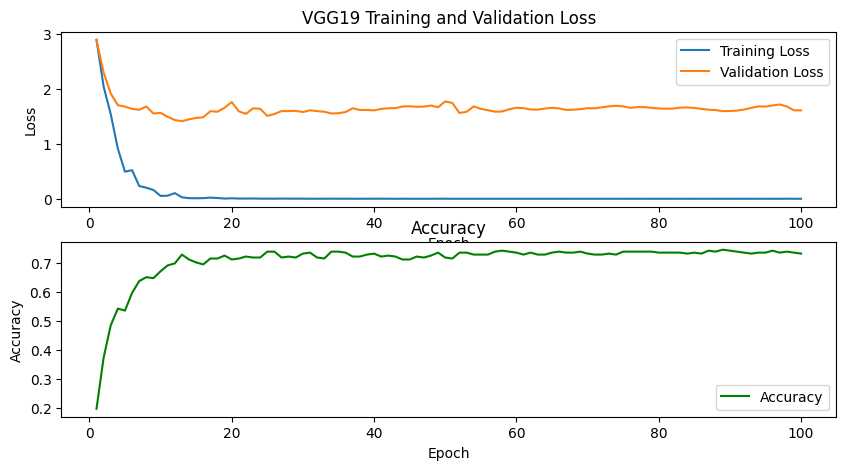

In [5]:
import matplotlib.pyplot as plt
epochs = list(range(1, len(vgg_training_logs) + 1))
loss_values = [entry['Loss'] for entry in vgg_training_logs]
val_loss_values = [entry['Validation Loss'] for entry in vgg_training_logs]
accuracy_values = [entry['accuracy'] for entry in vgg_training_logs]

# Plotting
plt.figure(figsize=(10, 5))

# Plot Loss
plt.subplot(2, 1, 1)
plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.title('VGG19 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, accuracy_values, label='Accuracy', color='green')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


## ResNet50 

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

resnet50 = models.resnet50(pretrained=True)

for param in resnet50.parameters():
    param.requires_grad = False

num_classes = len(dataset.classes)
resnet50.fc = nn.Sequential(
    nn.Linear(resnet50.fc.in_features, 1000),
    nn.ReLU(inplace=True),
    nn.Linear(1000, 256),
    nn.ReLU(inplace= True),
    nn.Linear(256, num_classes),
)
# resnet50.fc.append(nn.Linear(1000, 256))
# resnet50.fc.append(nn.ReLU())
# resnet50.fc.append(nn.Linear(256, num_classes))
# resnet50.fc.append( nn.Softmax(dim=1))



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s] 


In [7]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### TRAINING ResNet50

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=3e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50.to(device)

resnet_training_logs = []

num_epochs = 100

for epoch in tqdm(range(num_epochs)):
    epoch_log = {}
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        resnet50.eval()
        total_correct = 0
        total_samples = 0

        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = resnet50(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            _, predicted = torch.max(val_outputs, 1)
            total_correct += (predicted == val_labels).sum().item()
            total_samples += val_labels.size(0)

        accuracy = total_correct / total_samples
        

    resnet50.train()  

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Accuracy: {accuracy * 100:.2f}%')
    epoch_log['Loss'] =loss.item()
    epoch_log['Validation Loss'] = val_loss.item()
    epoch_log['accuracy'] = accuracy
    resnet_training_logs.append(epoch_log)

torch.save(resnet50.state_dict(), 'resnet50_model.pth')


  1%|          | 1/100 [00:04<07:59,  4.85s/it]

Epoch 1/100, Loss: 3.299046277999878, Validation Loss: 3.3837804794311523, Accuracy: 10.77%


  2%|▏         | 2/100 [00:09<07:41,  4.70s/it]

Epoch 2/100, Loss: 3.1747238636016846, Validation Loss: 3.2158455848693848, Accuracy: 21.89%


  3%|▎         | 3/100 [00:13<07:27,  4.61s/it]

Epoch 3/100, Loss: 3.047346830368042, Validation Loss: 3.0043041706085205, Accuracy: 20.88%


  4%|▍         | 4/100 [00:18<07:24,  4.63s/it]

Epoch 4/100, Loss: 2.7435648441314697, Validation Loss: 2.743298053741455, Accuracy: 29.29%


  5%|▌         | 5/100 [00:23<07:13,  4.57s/it]

Epoch 5/100, Loss: 2.468231439590454, Validation Loss: 2.5509018898010254, Accuracy: 41.08%


  6%|▌         | 6/100 [00:27<07:08,  4.56s/it]

Epoch 6/100, Loss: 2.1505696773529053, Validation Loss: 2.3647661209106445, Accuracy: 37.71%


  7%|▋         | 7/100 [00:32<07:02,  4.54s/it]

Epoch 7/100, Loss: 2.1394410133361816, Validation Loss: 2.1535537242889404, Accuracy: 43.43%


  8%|▊         | 8/100 [00:37<07:13,  4.71s/it]

Epoch 8/100, Loss: 1.771913766860962, Validation Loss: 1.9837555885314941, Accuracy: 46.13%


  9%|▉         | 9/100 [00:41<07:08,  4.71s/it]

Epoch 9/100, Loss: 1.7513347864151, Validation Loss: 1.9720418453216553, Accuracy: 49.16%


 10%|█         | 10/100 [00:46<06:57,  4.64s/it]

Epoch 10/100, Loss: 1.464402198791504, Validation Loss: 1.769532322883606, Accuracy: 48.15%


 11%|█         | 11/100 [00:51<06:59,  4.71s/it]

Epoch 11/100, Loss: 1.363355278968811, Validation Loss: 1.7990174293518066, Accuracy: 50.17%


 12%|█▏        | 12/100 [00:56<06:56,  4.73s/it]

Epoch 12/100, Loss: 1.3753764629364014, Validation Loss: 1.6806780099868774, Accuracy: 52.86%


 13%|█▎        | 13/100 [01:00<06:55,  4.78s/it]

Epoch 13/100, Loss: 1.303672432899475, Validation Loss: 1.7161778211593628, Accuracy: 52.53%


 14%|█▍        | 14/100 [01:05<06:45,  4.72s/it]

Epoch 14/100, Loss: 1.3134126663208008, Validation Loss: 1.4896990060806274, Accuracy: 56.57%


 15%|█▌        | 15/100 [01:10<06:37,  4.67s/it]

Epoch 15/100, Loss: 1.2758713960647583, Validation Loss: 1.5453927516937256, Accuracy: 55.56%


 16%|█▌        | 16/100 [01:14<06:25,  4.59s/it]

Epoch 16/100, Loss: 0.9180780649185181, Validation Loss: 1.420292854309082, Accuracy: 54.21%


 17%|█▋        | 17/100 [01:19<06:20,  4.59s/it]

Epoch 17/100, Loss: 1.0118963718414307, Validation Loss: 1.490983486175537, Accuracy: 53.87%


 18%|█▊        | 18/100 [01:23<06:16,  4.59s/it]

Epoch 18/100, Loss: 0.9023169279098511, Validation Loss: 1.4927067756652832, Accuracy: 57.24%


 19%|█▉        | 19/100 [01:28<06:08,  4.55s/it]

Epoch 19/100, Loss: 0.8045768737792969, Validation Loss: 1.4308075904846191, Accuracy: 56.90%


 20%|██        | 20/100 [01:32<06:05,  4.56s/it]

Epoch 20/100, Loss: 0.9875966310501099, Validation Loss: 1.446981430053711, Accuracy: 60.61%


 21%|██        | 21/100 [01:37<06:02,  4.59s/it]

Epoch 21/100, Loss: 0.7155560851097107, Validation Loss: 1.3765374422073364, Accuracy: 57.58%


 22%|██▏       | 22/100 [01:41<05:57,  4.59s/it]

Epoch 22/100, Loss: 0.8791711330413818, Validation Loss: 1.4738162755966187, Accuracy: 57.24%


 23%|██▎       | 23/100 [01:46<05:50,  4.55s/it]

Epoch 23/100, Loss: 0.7566397190093994, Validation Loss: 1.3088880777359009, Accuracy: 62.29%


 24%|██▍       | 24/100 [01:51<05:50,  4.61s/it]

Epoch 24/100, Loss: 0.6753841638565063, Validation Loss: 1.4035987854003906, Accuracy: 60.27%


 25%|██▌       | 25/100 [01:55<05:50,  4.67s/it]

Epoch 25/100, Loss: 0.6601905226707458, Validation Loss: 1.4292469024658203, Accuracy: 56.23%


 26%|██▌       | 26/100 [02:00<05:46,  4.68s/it]

Epoch 26/100, Loss: 0.3953605890274048, Validation Loss: 1.3166768550872803, Accuracy: 59.93%


 27%|██▋       | 27/100 [02:05<05:39,  4.65s/it]

Epoch 27/100, Loss: 0.5123848915100098, Validation Loss: 1.3149645328521729, Accuracy: 57.91%


 28%|██▊       | 28/100 [02:09<05:34,  4.65s/it]

Epoch 28/100, Loss: 0.7154442667961121, Validation Loss: 1.3260730504989624, Accuracy: 58.92%


 29%|██▉       | 29/100 [02:14<05:29,  4.64s/it]

Epoch 29/100, Loss: 0.39646676182746887, Validation Loss: 1.316973090171814, Accuracy: 58.59%


 30%|███       | 30/100 [02:19<05:26,  4.66s/it]

Epoch 30/100, Loss: 0.40182459354400635, Validation Loss: 1.3075737953186035, Accuracy: 61.62%


 31%|███       | 31/100 [02:23<05:23,  4.69s/it]

Epoch 31/100, Loss: 0.3897077441215515, Validation Loss: 1.3353688716888428, Accuracy: 59.93%


 32%|███▏      | 32/100 [02:28<05:16,  4.65s/it]

Epoch 32/100, Loss: 0.45944955945014954, Validation Loss: 1.334168553352356, Accuracy: 58.25%


 33%|███▎      | 33/100 [02:33<05:12,  4.67s/it]

Epoch 33/100, Loss: 0.3211233615875244, Validation Loss: 1.3267908096313477, Accuracy: 60.61%


 34%|███▍      | 34/100 [02:38<05:12,  4.73s/it]

Epoch 34/100, Loss: 0.5509248375892639, Validation Loss: 1.3183419704437256, Accuracy: 59.60%


 35%|███▌      | 35/100 [02:42<05:04,  4.69s/it]

Epoch 35/100, Loss: 0.3590717613697052, Validation Loss: 1.295744776725769, Accuracy: 61.95%


 36%|███▌      | 36/100 [02:47<04:54,  4.61s/it]

Epoch 36/100, Loss: 0.3682800531387329, Validation Loss: 1.3452006578445435, Accuracy: 61.62%


 37%|███▋      | 37/100 [02:51<04:45,  4.54s/it]

Epoch 37/100, Loss: 0.22254668176174164, Validation Loss: 1.319439172744751, Accuracy: 62.29%


 38%|███▊      | 38/100 [02:56<04:43,  4.57s/it]

Epoch 38/100, Loss: 0.37872835993766785, Validation Loss: 1.371978521347046, Accuracy: 58.92%


 39%|███▉      | 39/100 [03:00<04:38,  4.57s/it]

Epoch 39/100, Loss: 0.4720870852470398, Validation Loss: 1.3027117252349854, Accuracy: 62.63%


 40%|████      | 40/100 [03:05<04:31,  4.52s/it]

Epoch 40/100, Loss: 0.28016167879104614, Validation Loss: 1.3019907474517822, Accuracy: 62.96%


 41%|████      | 41/100 [03:09<04:27,  4.53s/it]

Epoch 41/100, Loss: 0.18353697657585144, Validation Loss: 1.2457520961761475, Accuracy: 60.61%


 42%|████▏     | 42/100 [03:14<04:23,  4.54s/it]

Epoch 42/100, Loss: 0.32656508684158325, Validation Loss: 1.3139827251434326, Accuracy: 62.29%


 43%|████▎     | 43/100 [03:18<04:22,  4.61s/it]

Epoch 43/100, Loss: 0.2755711078643799, Validation Loss: 1.3855347633361816, Accuracy: 59.93%


 44%|████▍     | 44/100 [03:23<04:13,  4.54s/it]

Epoch 44/100, Loss: 0.21165184676647186, Validation Loss: 1.2702043056488037, Accuracy: 63.30%


 45%|████▌     | 45/100 [03:27<04:11,  4.57s/it]

Epoch 45/100, Loss: 0.25698933005332947, Validation Loss: 1.395082950592041, Accuracy: 59.60%


 46%|████▌     | 46/100 [03:32<04:05,  4.55s/it]

Epoch 46/100, Loss: 0.2658501863479614, Validation Loss: 1.2702012062072754, Accuracy: 64.31%


 47%|████▋     | 47/100 [03:37<04:00,  4.54s/it]

Epoch 47/100, Loss: 0.2801964282989502, Validation Loss: 1.3054040670394897, Accuracy: 63.97%


 48%|████▊     | 48/100 [03:41<03:57,  4.57s/it]

Epoch 48/100, Loss: 0.16253496706485748, Validation Loss: 1.3942468166351318, Accuracy: 61.62%


 49%|████▉     | 49/100 [03:46<03:53,  4.57s/it]

Epoch 49/100, Loss: 0.1438887119293213, Validation Loss: 1.2691839933395386, Accuracy: 64.65%


 50%|█████     | 50/100 [03:50<03:45,  4.52s/it]

Epoch 50/100, Loss: 0.18468615412712097, Validation Loss: 1.369638204574585, Accuracy: 64.98%


 51%|█████     | 51/100 [03:55<03:42,  4.54s/it]

Epoch 51/100, Loss: 0.19776450097560883, Validation Loss: 1.3587266206741333, Accuracy: 63.64%


 52%|█████▏    | 52/100 [03:59<03:40,  4.60s/it]

Epoch 52/100, Loss: 0.322163462638855, Validation Loss: 1.3016602993011475, Accuracy: 62.96%


 53%|█████▎    | 53/100 [04:04<03:35,  4.59s/it]

Epoch 53/100, Loss: 0.27877160906791687, Validation Loss: 1.443828821182251, Accuracy: 58.92%


 54%|█████▍    | 54/100 [04:09<03:31,  4.59s/it]

Epoch 54/100, Loss: 0.278633177280426, Validation Loss: 1.2737250328063965, Accuracy: 63.97%


 55%|█████▌    | 55/100 [04:13<03:24,  4.55s/it]

Epoch 55/100, Loss: 0.16960196197032928, Validation Loss: 1.374822974205017, Accuracy: 64.31%


 56%|█████▌    | 56/100 [04:17<03:18,  4.51s/it]

Epoch 56/100, Loss: 0.1314278244972229, Validation Loss: 1.4014934301376343, Accuracy: 63.30%


 57%|█████▋    | 57/100 [04:22<03:12,  4.48s/it]

Epoch 57/100, Loss: 0.1506388932466507, Validation Loss: 1.2264127731323242, Accuracy: 64.98%


 58%|█████▊    | 58/100 [04:26<03:08,  4.49s/it]

Epoch 58/100, Loss: 0.17951427400112152, Validation Loss: 1.4210906028747559, Accuracy: 60.27%


 59%|█████▉    | 59/100 [04:31<03:08,  4.59s/it]

Epoch 59/100, Loss: 0.14849792420864105, Validation Loss: 1.292096734046936, Accuracy: 64.65%


 60%|██████    | 60/100 [04:36<03:02,  4.56s/it]

Epoch 60/100, Loss: 0.1066540852189064, Validation Loss: 1.3955988883972168, Accuracy: 59.93%


 61%|██████    | 61/100 [04:40<03:00,  4.62s/it]

Epoch 61/100, Loss: 0.10711970180273056, Validation Loss: 1.3740432262420654, Accuracy: 64.98%


 62%|██████▏   | 62/100 [04:45<02:55,  4.61s/it]

Epoch 62/100, Loss: 0.14897538721561432, Validation Loss: 1.360181450843811, Accuracy: 61.95%


 63%|██████▎   | 63/100 [04:49<02:47,  4.53s/it]

Epoch 63/100, Loss: 0.09965993463993073, Validation Loss: 1.3768376111984253, Accuracy: 64.98%


 64%|██████▍   | 64/100 [04:54<02:43,  4.56s/it]

Epoch 64/100, Loss: 0.13702023029327393, Validation Loss: 1.37990140914917, Accuracy: 63.64%


 65%|██████▌   | 65/100 [04:59<02:39,  4.55s/it]

Epoch 65/100, Loss: 0.09571532905101776, Validation Loss: 1.3637210130691528, Accuracy: 63.30%


 66%|██████▌   | 66/100 [05:03<02:35,  4.58s/it]

Epoch 66/100, Loss: 0.07586067914962769, Validation Loss: 1.3723185062408447, Accuracy: 63.97%


 67%|██████▋   | 67/100 [05:08<02:33,  4.65s/it]

Epoch 67/100, Loss: 0.1022072583436966, Validation Loss: 1.361667275428772, Accuracy: 63.64%


 68%|██████▊   | 68/100 [05:13<02:30,  4.71s/it]

Epoch 68/100, Loss: 0.09265144169330597, Validation Loss: 1.3512558937072754, Accuracy: 62.96%


 69%|██████▉   | 69/100 [05:17<02:25,  4.68s/it]

Epoch 69/100, Loss: 0.11238791048526764, Validation Loss: 1.4033641815185547, Accuracy: 63.64%


 70%|███████   | 70/100 [05:22<02:17,  4.60s/it]

Epoch 70/100, Loss: 0.11549617350101471, Validation Loss: 1.4158473014831543, Accuracy: 63.30%


 71%|███████   | 71/100 [05:26<02:12,  4.57s/it]

Epoch 71/100, Loss: 0.08888421952724457, Validation Loss: 1.3168517351150513, Accuracy: 65.66%


 72%|███████▏  | 72/100 [05:31<02:08,  4.58s/it]

Epoch 72/100, Loss: 0.11622089147567749, Validation Loss: 1.4301611185073853, Accuracy: 62.96%


 73%|███████▎  | 73/100 [05:36<02:05,  4.64s/it]

Epoch 73/100, Loss: 0.09229163825511932, Validation Loss: 1.443037748336792, Accuracy: 61.62%


 74%|███████▍  | 74/100 [05:40<01:59,  4.60s/it]

Epoch 74/100, Loss: 0.08026445657014847, Validation Loss: 1.4220179319381714, Accuracy: 63.64%


 75%|███████▌  | 75/100 [05:45<01:54,  4.57s/it]

Epoch 75/100, Loss: 0.05815262719988823, Validation Loss: 1.353327989578247, Accuracy: 63.97%


 76%|███████▌  | 76/100 [05:49<01:48,  4.51s/it]

Epoch 76/100, Loss: 0.05881824716925621, Validation Loss: 1.4086658954620361, Accuracy: 61.95%


 77%|███████▋  | 77/100 [05:54<01:45,  4.57s/it]

Epoch 77/100, Loss: 0.06454697996377945, Validation Loss: 1.4604206085205078, Accuracy: 64.98%


 78%|███████▊  | 78/100 [05:59<01:46,  4.85s/it]

Epoch 78/100, Loss: 0.12328530848026276, Validation Loss: 1.400626301765442, Accuracy: 61.95%


 79%|███████▉  | 79/100 [06:04<01:43,  4.93s/it]

Epoch 79/100, Loss: 0.06955402344465256, Validation Loss: 1.4270071983337402, Accuracy: 64.65%


 80%|████████  | 80/100 [06:09<01:36,  4.84s/it]

Epoch 80/100, Loss: 0.05597204342484474, Validation Loss: 1.3853864669799805, Accuracy: 65.66%


 81%|████████  | 81/100 [06:14<01:30,  4.75s/it]

Epoch 81/100, Loss: 0.05195988342165947, Validation Loss: 1.4760451316833496, Accuracy: 63.64%


 82%|████████▏ | 82/100 [06:18<01:23,  4.64s/it]

Epoch 82/100, Loss: 0.062151823192834854, Validation Loss: 1.3876774311065674, Accuracy: 64.98%


 83%|████████▎ | 83/100 [06:22<01:17,  4.58s/it]

Epoch 83/100, Loss: 0.07153543084859848, Validation Loss: 1.499221682548523, Accuracy: 62.63%


 84%|████████▍ | 84/100 [06:27<01:12,  4.52s/it]

Epoch 84/100, Loss: 0.03359442204236984, Validation Loss: 1.430591344833374, Accuracy: 64.98%


 85%|████████▌ | 85/100 [06:31<01:07,  4.53s/it]

Epoch 85/100, Loss: 0.04169059172272682, Validation Loss: 1.4509936571121216, Accuracy: 62.96%


 86%|████████▌ | 86/100 [06:36<01:04,  4.61s/it]

Epoch 86/100, Loss: 0.047195155173540115, Validation Loss: 1.4459501504898071, Accuracy: 63.30%


 87%|████████▋ | 87/100 [06:41<01:00,  4.62s/it]

Epoch 87/100, Loss: 0.13041260838508606, Validation Loss: 1.4236589670181274, Accuracy: 62.96%


 88%|████████▊ | 88/100 [06:46<00:55,  4.63s/it]

Epoch 88/100, Loss: 0.06061246246099472, Validation Loss: 1.4504873752593994, Accuracy: 62.63%


 89%|████████▉ | 89/100 [06:50<00:50,  4.61s/it]

Epoch 89/100, Loss: 0.03289157524704933, Validation Loss: 1.517212986946106, Accuracy: 61.62%


 90%|█████████ | 90/100 [06:55<00:46,  4.62s/it]

Epoch 90/100, Loss: 0.05773744359612465, Validation Loss: 1.4850126504898071, Accuracy: 63.64%


 91%|█████████ | 91/100 [06:59<00:41,  4.60s/it]

Epoch 91/100, Loss: 0.15547214448451996, Validation Loss: 1.4881795644760132, Accuracy: 65.66%


 92%|█████████▏| 92/100 [07:04<00:36,  4.55s/it]

Epoch 92/100, Loss: 0.0392063669860363, Validation Loss: 1.5521314144134521, Accuracy: 61.95%


 93%|█████████▎| 93/100 [07:09<00:32,  4.63s/it]

Epoch 93/100, Loss: 0.02903435379266739, Validation Loss: 1.4983103275299072, Accuracy: 63.64%


 94%|█████████▍| 94/100 [07:13<00:27,  4.60s/it]

Epoch 94/100, Loss: 0.05925813689827919, Validation Loss: 1.4727250337600708, Accuracy: 64.98%


 95%|█████████▌| 95/100 [07:18<00:23,  4.61s/it]

Epoch 95/100, Loss: 0.07624315470457077, Validation Loss: 1.4777181148529053, Accuracy: 64.31%


 96%|█████████▌| 96/100 [07:22<00:18,  4.60s/it]

Epoch 96/100, Loss: 0.05005107820034027, Validation Loss: 1.5742155313491821, Accuracy: 64.65%


 97%|█████████▋| 97/100 [07:27<00:13,  4.58s/it]

Epoch 97/100, Loss: 0.12082544714212418, Validation Loss: 1.4612741470336914, Accuracy: 65.32%


 98%|█████████▊| 98/100 [07:31<00:09,  4.54s/it]

Epoch 98/100, Loss: 0.049929432570934296, Validation Loss: 1.5727874040603638, Accuracy: 61.62%


 99%|█████████▉| 99/100 [07:36<00:04,  4.53s/it]

Epoch 99/100, Loss: 0.10643967241048813, Validation Loss: 1.5793739557266235, Accuracy: 64.65%


100%|██████████| 100/100 [07:40<00:00,  4.61s/it]

Epoch 100/100, Loss: 0.041910089552402496, Validation Loss: 1.537644624710083, Accuracy: 62.29%


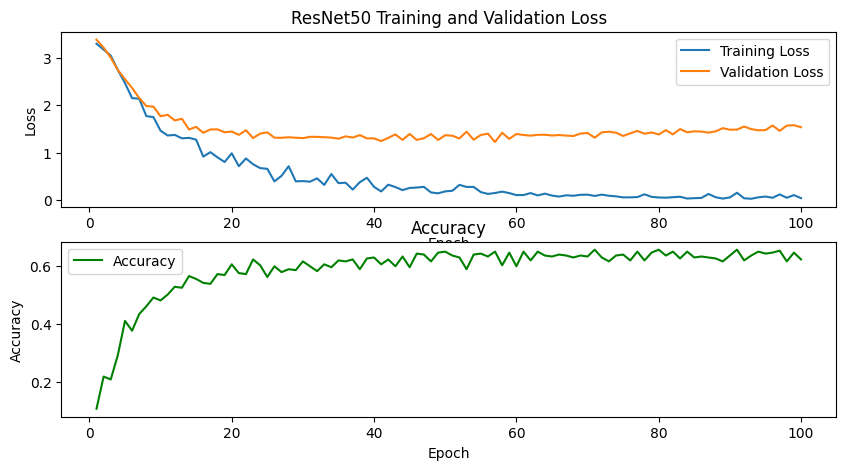

In [9]:
import matplotlib.pyplot as plt
epochs = list(range(1, len(resnet_training_logs) + 1))
loss_values = [entry['Loss'] for entry in resnet_training_logs]
val_loss_values = [entry['Validation Loss'] for entry in resnet_training_logs]
accuracy_values = [entry['accuracy'] for entry in resnet_training_logs]

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.title('ResNet50 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(epochs, accuracy_values, label='Accuracy', color='green')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


## EVALUATING THE RESULTS

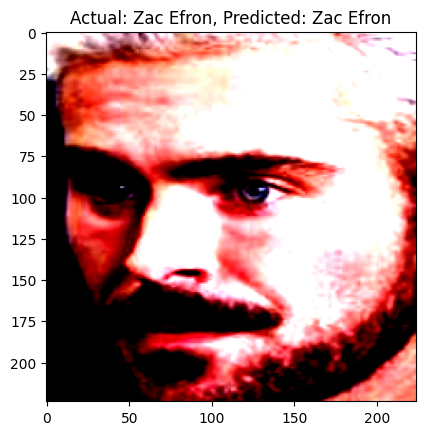

In [15]:
resnet50.eval()
random_index = random.randint(0, len(val_loader.dataset) - 1)
sample_inputs, sample_labels = val_loader.dataset[random_index]
class_labels = dataset.classes 


sample_inputs = sample_inputs.unsqueeze(0).to(device)

with torch.no_grad():
    sample_outputs = resnet50(sample_inputs)

_, predicted_label = torch.max(sample_outputs, 1)

# Convert to CPU for printing
actual_label = sample_labels
predicted_label = predicted_label

# Convert the PyTorch tensor to a NumPy array for visualization
sample_image = sample_inputs.cpu().squeeze(0).permute(1, 2, 0).numpy()

# Display the image along with actual and predicted labels
plt.imshow(sample_image)
plt.title(f'Actual: {class_labels[actual_label]}, Predicted: {class_labels[predicted_label]}')
plt.show()


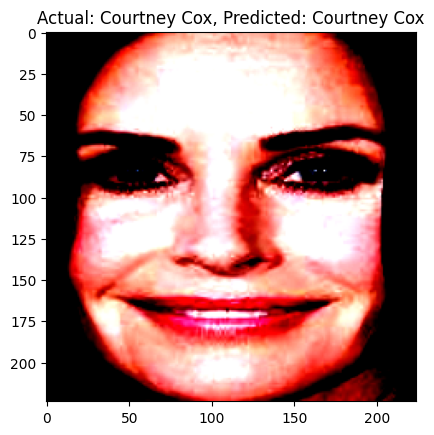

In [11]:
import random
import matplotlib.pyplot as plt

vgg_net.eval()
class_labels = dataset.classes 

random_index = random.randint(0, len(val_loader.dataset) - 1)
sample_inputs, sample_labels = val_loader.dataset[random_index]

sample_inputs = sample_inputs.unsqueeze(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg_net.to(device)

sample_inputs = sample_inputs.to(device)

with torch.no_grad():
    sample_outputs = vgg_net(sample_inputs)

_, predicted_label = torch.max(sample_outputs, 1)

actual_label = sample_labels
predicted_label = predicted_label

sample_image = sample_inputs.cpu().squeeze(0).permute(1, 2, 0).numpy()

plt.imshow(sample_image)
plt.title(f'Actual: {class_labels[actual_label]}, Predicted: {class_labels[predicted_label]}')
plt.show()


## CLASSIFICATION REPORT 

### VGG19

In [12]:
import torch
from sklearn.metrics import classification_report

vgg_net.eval()

true_labels = []
predicted_labels = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_net.to(device)

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = vgg_net(inputs)

        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

class_names = dataset.classes
report = classification_report(true_labels, predicted_labels, target_names=class_names)

print(report)


                    precision    recall  f1-score   support

      Akshay Kumar       0.80      0.57      0.67         7
Alexandra Daddario       0.86      1.00      0.92         6
        Alia Bhatt       0.73      0.67      0.70        12
  Amitabh Bachchan       1.00      1.00      1.00        13
      Andy Samberg       0.57      0.57      0.57         7
    Anushka Sharma       0.58      0.70      0.64        10
     Billie Eilish       0.92      0.92      0.92        13
         Brad Pitt       0.78      0.70      0.74        10
    Camila Cabello       0.83      0.62      0.71         8
   Charlize Theron       0.50      0.40      0.44        10
       Claire Holt       0.46      0.50      0.48        12
      Courtney Cox       0.55      0.55      0.55        11
    Dwayne Johnson       0.80      1.00      0.89         4
   Elizabeth Olsen       0.50      0.71      0.59         7
   Ellen Degeneres       1.00      0.92      0.96        13
      Henry Cavill       0.86      0.60

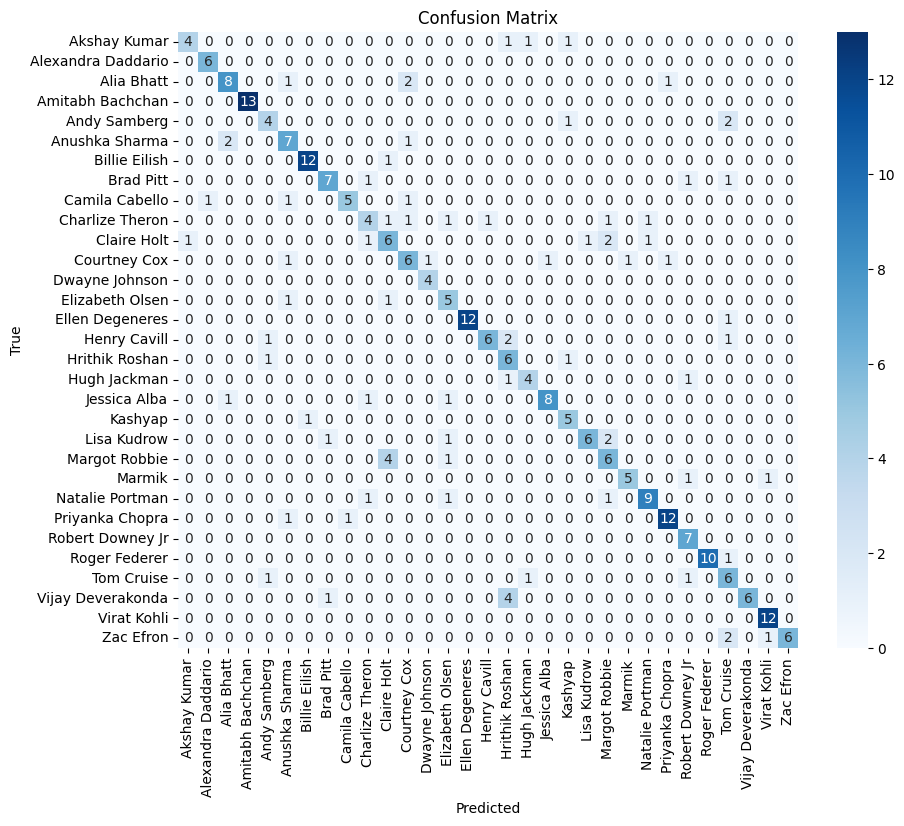

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### ResNet50

In [16]:
import torch
from sklearn.metrics import classification_report

resnet50.eval()

true_labels = []
predicted_labels = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50.to(device)

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = resnet50(inputs)

        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

class_names = dataset.classes
report = classification_report(true_labels, predicted_labels, target_names=class_names)

print(report)


                    precision    recall  f1-score   support

      Akshay Kumar       0.67      0.29      0.40         7
Alexandra Daddario       0.36      0.67      0.47         6
        Alia Bhatt       0.64      0.58      0.61        12
  Amitabh Bachchan       1.00      0.85      0.92        13
      Andy Samberg       0.50      0.57      0.53         7
    Anushka Sharma       0.50      0.50      0.50        10
     Billie Eilish       0.91      0.77      0.83        13
         Brad Pitt       0.39      0.70      0.50        10
    Camila Cabello       0.46      0.75      0.57         8
   Charlize Theron       0.67      0.80      0.73        10
       Claire Holt       0.29      0.17      0.21        12
      Courtney Cox       0.71      0.45      0.56        11
    Dwayne Johnson       0.60      0.75      0.67         4
   Elizabeth Olsen       0.50      0.57      0.53         7
   Ellen Degeneres       0.91      0.77      0.83        13
      Henry Cavill       0.75      0.30

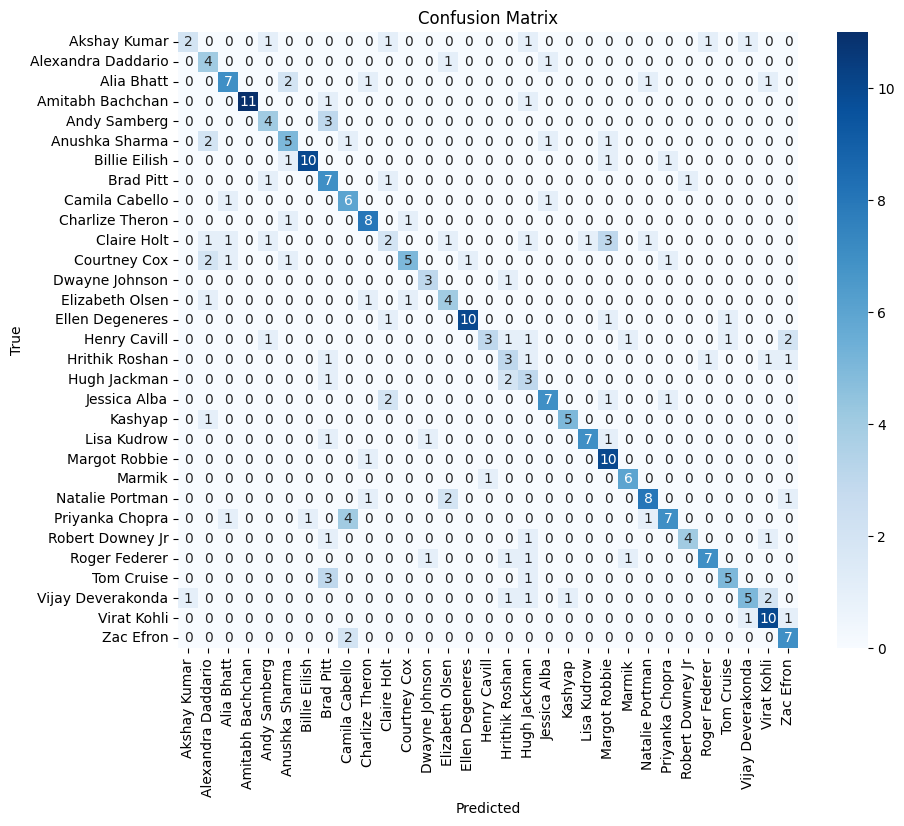

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()